<a href="https://colab.research.google.com/github/sujit-deokar/SVHN_Dataset/blob/main/RESNET_SVHN_Usecase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir("/content/gdrive/My Drive/SVHN_Dataset") # path to change

In [3]:
from __future__ import print_function
import keras
import tensorflow as tf
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Concatenate, Add, Lambda,AveragePooling2D
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, multiply, Permute, Input, Flatten
from keras.activations import sigmoid
#from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
#from models import resnext, resnet_v1, resnet_v2, mobilenets, inception_v3, inception_resnet_v2, densenet
#from utils import lr_schedule
import numpy as np
import os
import keras
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
%matplotlib inline
from keras.utils.vis_utils import plot_model

In [4]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 40:
        lr *= 0.5e-3
    elif epoch > 30:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [5]:

def resnet_layer(inputs,num_filters=16,kernel_size=3,strides=1,activation='relu',batch_normalization=True,conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def cbam_block(cbam_feature, ratio=8):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])


In [6]:
# Load the data
train_raw = loadmat('train_32x32.mat')
test_raw = loadmat('test_32x32.mat')
# Load images and labels

train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])

train_labels = train_raw['y']
test_labels = test_raw['y']
# Check the shape of the data

print(train_images.shape)
print(test_images.shape)
# Fix the axes of the images

train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

print(train_images.shape)
print(test_images.shape)

# Convert train and test images into 'float64' type

train_images = train_images.astype('float64')
test_images = test_images.astype('float64')

# Convert train and test labels into 'int64' type

train_labels = train_labels.astype('int64')
test_labels = test_labels.astype('int64')

# Normalize the images data

print('Min: {}, Max: {}'.format(train_images.min(), train_images.max()))

train_images /= 255.0
test_images /= 255.0

# One-hot encoding of train and test labels

lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

(32, 32, 3, 73257)
(32, 32, 3, 26032)
(73257, 32, 32, 3)
(26032, 32, 32, 3)
Min: 0.0, Max: 255.0


In [7]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels,test_size=0.15, random_state=22)
datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

In [8]:
num_filters = 16
num_res_blocks = 1
inputs = Input(shape=(32, 32, 3))
x = resnet_layer(inputs=inputs)
# Instantiate the stack of residual units
for stack in range(3):
    for res_block in range(num_res_blocks):
        strides = 1
        if stack > 0 and res_block == 0:  # first layer but not first stack
            strides = 2  # downsample
        y = resnet_layer(inputs=x,
                         num_filters=num_filters,
                         strides=strides)
        y = resnet_layer(inputs=y,
                         num_filters=num_filters,
                         activation=None)
        if stack > 0 and res_block == 0:  # first layer but not first stack
            # linear projection residual shortcut connection to match
            # changed dims
            x = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             kernel_size=1,
                             strides=strides,
                             activation=None,
                             batch_normalization=False)
        # attention_module
        #y = cbam_block(y)
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)
    num_filters *= 2

# Add classifier on top.
# v1 does not use BN after last shortcut connection-ReLU
x = AveragePooling2D(pool_size=8)(x)
y = Flatten()(x)
outputs = Dense(10,
                activation='softmax',
                kernel_initializer='he_normal')(y)

# Instantiate model.
model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


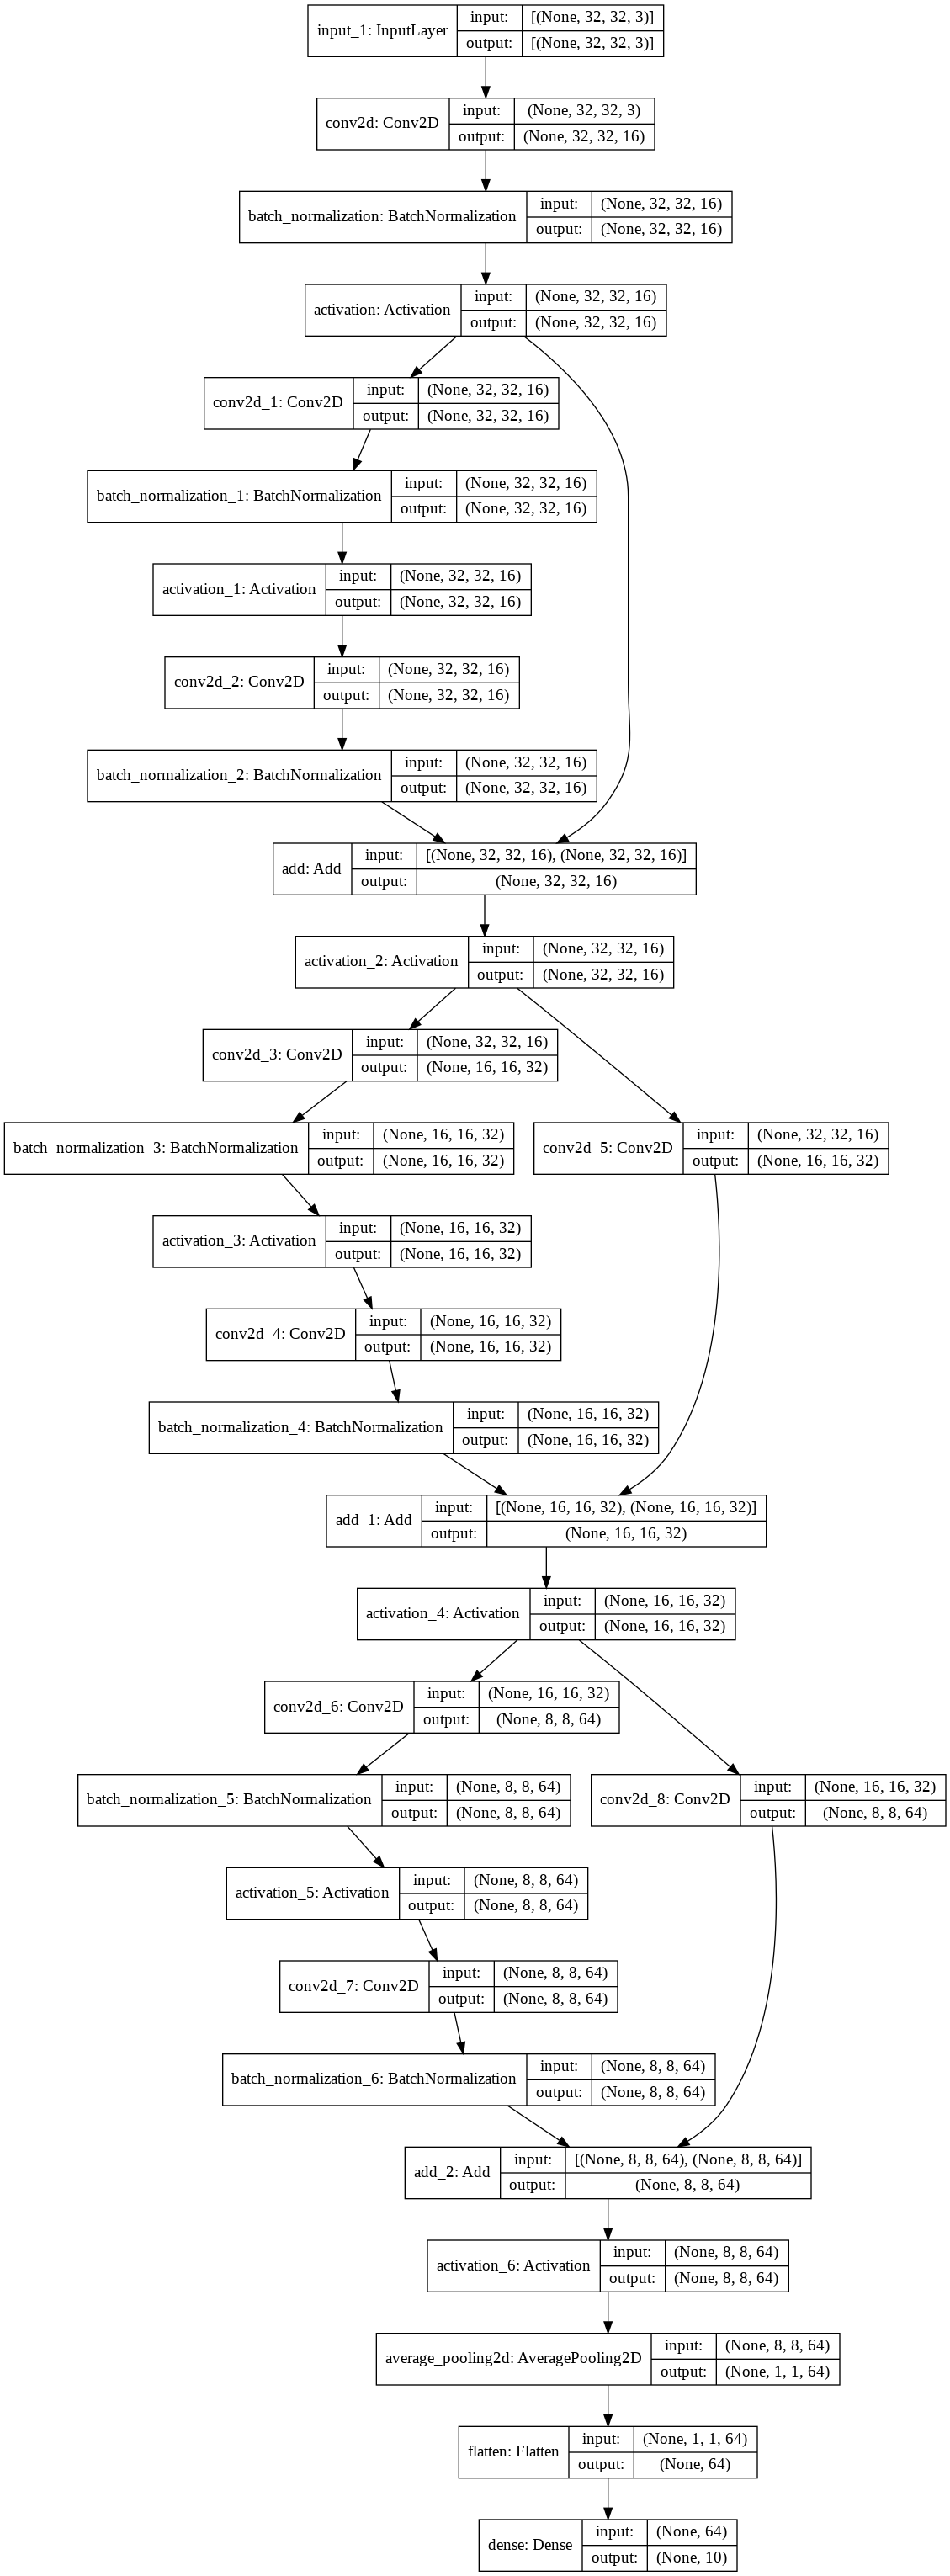

In [9]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [10]:
model_type = 'Resnet'
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models_1')
model_name = 'SVHN_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]
X_train, X_val, y_train, y_val
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                        validation_data=(X_val, y_val),
                        epochs=35, verbose=1, workers=4,
                        callbacks=callbacks)

Resnet


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/35
Learning rate:  0.001
487/487 [==============================] - 103s 145ms/step - loss: 1.7233 - accuracy: 0.4429 - val_loss: 1.2341 - val_accuracy: 0.6197

Epoch 00001: val_accuracy improved from -inf to 0.61971, saving model to /content/gdrive/My Drive/SVHN_Dataset/saved_models_1/SVHN_Resnet_model.001.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/35
Learning rate:  0.001
487/487 [==============================] - 71s 145ms/step - loss: 0.8237 - accuracy: 0.7725 - val_loss: 0.7789 - val_accuracy: 0.7770

Epoch 00002: val_accuracy improved from 0.61971 to 0.77696, saving model to /content/gdrive/My Drive/SVHN_Dataset/saved_models_1/SVHN_Resnet_model.002.h5
Epoch 3/35
Learning rate:  0.001
487/487 [==============================] - 70s 143ms/step - loss: 0.5852 - accuracy: 0.8439 - val_loss: 0.6689 - val_accuracy: 0.8080

Epoch 00003: val_accuracy improved from 0.77696 to 0.80799, saving model to /content/gdrive/My Drive/SVHN_Dataset/saved_models_1/SVHN_Resnet_model.003.h5
Epoch 4/35
Learning rate:  0.001
487/487 [==============================] - 71s 145ms/step - loss: 0.5008 - accuracy: 0.8681 - val_loss: 0.6195 - val_accuracy: 0.8335

Epoch 00004: val_accuracy improved from 0.80799 to 0.83347, saving model to /content/gdrive/My Drive/SVHN_Dataset/saved_models_1/SVHN_Resnet_model.004.h5
Epoch 5/35
Learning rate:  0.001
4

In [11]:
# Get predictions and apply inverse transformation to the labels

y_pred = model.predict(X_train)

y_pred = lb.inverse_transform(y_pred, lb.classes_)
y_train = lb.inverse_transform(y_train, lb.classes_)

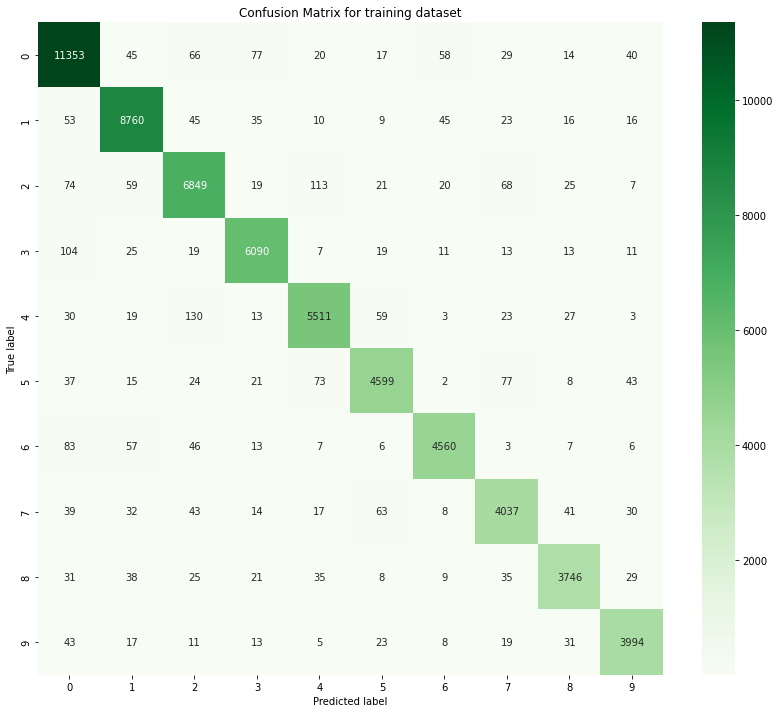

In [12]:
# Plot the confusion matrix

matrix = confusion_matrix(y_train, y_pred, labels=lb.classes_)

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [13]:
# Ignore the errors in the plots

np.seterr(all='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [14]:
# Get convolutional layers

layers = [model.get_layer('conv2d_1'), 
          model.get_layer('conv2d_2'),
          model.get_layer('conv2d_3'),
          model.get_layer('conv2d_4'),
          model.get_layer('conv2d_5'),
          model.get_layer('conv2d_6'),
          model.get_layer('conv2d_7'),
          model.get_layer('conv2d_8')]

In [15]:
# Define a model which gives the outputs of the layers

layer_outputs = [layer.output for layer in layers]
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)

In [16]:
# Create a list with the names of the layers

layer_names = []
for layer in layers:
    layer_names.append(layer.name)

In [17]:
# Define a function which will plot the convolutional filters

def plot_convolutional_filters(img):
    
    img = np.expand_dims(img, axis=0)
    activations = activation_model.predict(img)
    images_per_row = 9
    
    for layer_name, layer_activation in zip(layer_names, activations): 
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): 
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='plasma')

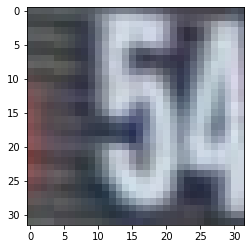

In [18]:
img = X_train[42500]
plt.imshow(img)
plt.show()

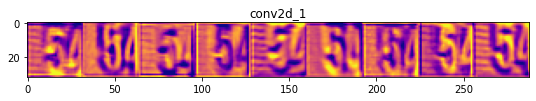

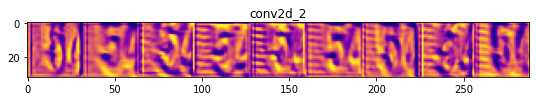

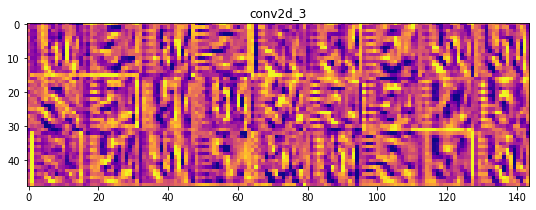

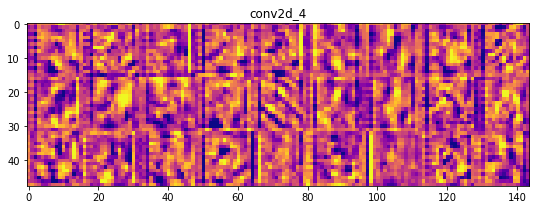

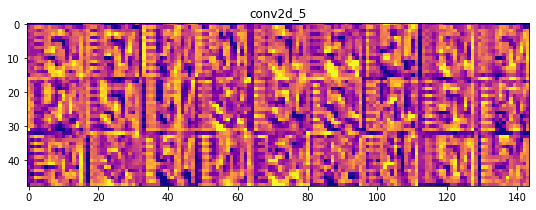

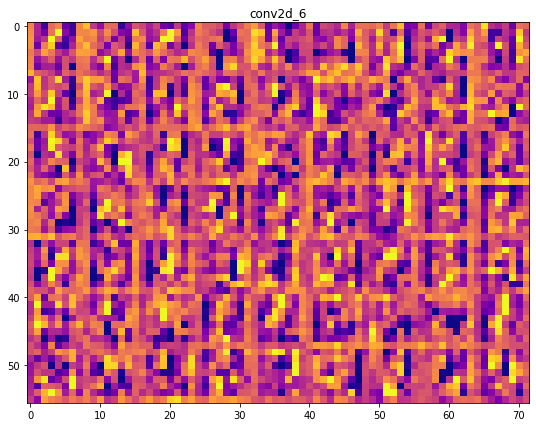

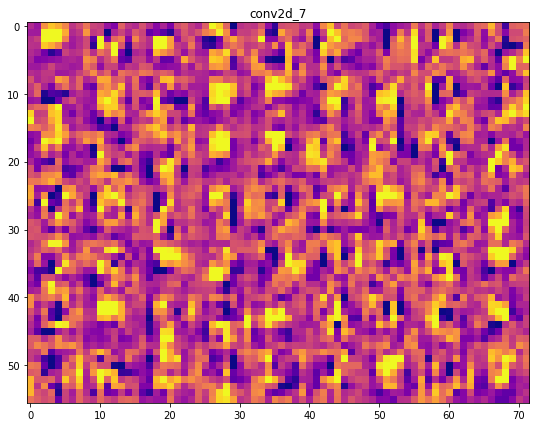

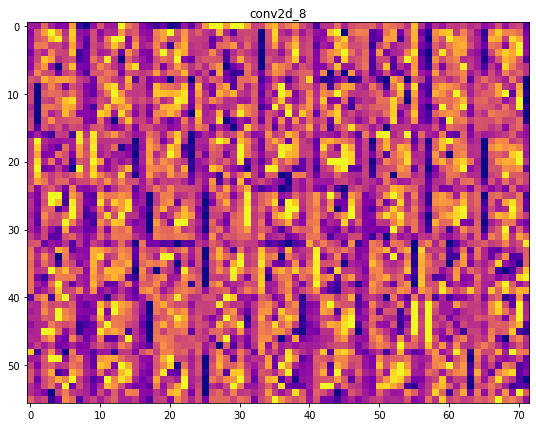

In [19]:
plot_convolutional_filters(img)